# Прогнозирование оттока клиентов

### Дипломный проект Специализации "Машинное обучение и анализ данных" на Coursera

https://www.coursera.org/specializations/machine-learning-data-analysis

__Постановка задачи:__

В 2009 году проводилось соревнование KDD Cup: Customer relationship prediction (http://www.kdd.org/kdd-cup/view/kdd-cup-2009/Intro). Данные для соревнования были предоставлены французской телекоммуникационной компанией Orange. В задаче речь шла о клиентских данных, поэтому данные были предварительно обфусцированы и анонимизированны: из датасета убрана любая персональная информация, позволяющая идентифицировать пользователей, а также не представлены названия и описания переменных, предназначенных для построения прогнозов. 

Для дипломного проекта взяты данные из этого соревнования. Обучающий и тестовый датасеты доступны на тренировочном полигоне диплома по адресу: https://www.kaggle.com/c/telecom-clients-churn-prediction/

В рамках диплома решается задача прогнозирования оттока пользователей, или churn prediction. Речь идет о вероятностной модели бинарной классификации, где целевой класс представляют собой пользователи, покидающие сервис. Вероятность того, что пользователь принадлежит целевому классу и есть целевая величина – вероятность оттока, которую нужно научиться предсказывать.

## Часть 3. Оценка потенциального экономического эффекта от внедрения полученного решения

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Параметров у модели будет много, поэтому я буду собирать их все в один словарь:

In [2]:
model_params = {}

## Предположения, в которых строится оценка экономического эффекта

Все расчеты и показатели, используемые далее, приведены к месячному измерению. Горизонт анализа составляет 2 месяца: нулевой - оценка базовых значений для дальнейшего сравнения, первый месяц - расходы на кампанию по удержанию клиентов и полученные за этот месяц от кампании доходы за счет возврата части клиентов.

По-серьезному, оценку нужно делать в перспективе на, минимум, квартал, а еще лучше - полгода. Но в рамках диплома я это делать не буду - схема будет точно такая же, но каждый следующий месяц оценивается относительно предыдущего с учетом изменений, вносимых моделью.

Поскольку речь идет о деньгах организации, оценку нужно делать с учетом окружения модели, в которое входят:

- расходы организации: для телекома основными расходами являются капитальные затраты, на фоне которых расходы, связанные с клиентами, ничтожны. Поэтому последние можно игнорировать и считать, что (__Предположение 1__) ежемесячные расходы константны и не зависят от оттока/притока и вообще от размера клиентской базы. 

- доходы организации: а вот они как раз напрямую зависят от денег, которые приносят клиенты. Упростим модель и будем считать, что (__Предположение 2__) величина ежемесячных доходов в точности равна количеству клиентов в этом месяце, умноженному на средний доход от одного клиента. 

Можно, конечно, ограничиться только теми параметрами, которые напрямую связаны с моделью, но мне интересно сравнить показатели с общей ситуацией. Иначе может получиться "драка за копейки на фоне миллионов".

__Предположение 3:__ нам откуда-то известны бизнес-показатели организации:

In [3]:
model_params['capital_cost'] = 400000000      # ежемесячные расходы (константа)
model_params['number_of_clients'] = 1000000   # количество клиентов в месяц, предшествующий кампании по удержанию
model_params['income_from_client'] = 500      # средний ежемесячный доход от одного клиента
model_params['cost_of_withholding'] = 100     # сколько денег будет вкладываться в удержание одного клиента в месяц
model_params['probability_of_accepting'] = .5 # вероятность принятия предложения клиентом в рамках кампании
model_params['fraction_of_clients'] = .25     # доля клиентов, включенных в кампанию, от списка, представленного моделью
model_params['month_churn'] = .0744           # доля оттока за нулевой месяц от общего количества клиентов

Еще одной спецификой телекома является естественная миграция абонентов. Это тот отток, который компенсируется притоком, и с которым нет смысла работать вообще. Это - поправка к оценке прогноза модели.

__Предположение 4:__ нам откуда-то известно, что величина естественной миграции в месяц составляет 1% от количества клиентов:

In [4]:
model_params['natural_churn'] = .01

Кроме того, оценка экономического эффекта имеет нижнюю границу разумного - проведение кампании должно быть выгоднее, чем помещение тех же денег на месяц в банк под проценты. 

__Предположение 5__: организация имеет возможность класть любую сумму на счет на 1 месяц под 7% годовых.

In [5]:
model_params['bank_month_procent'] = .07 / 12

__Предположение 6:__ для оценки экономического эффекта будут использоваться две метрики - точность и полнота прогнозов построенной модели по классу оттока.

In [6]:
model_params['precision_churn'] = .99
model_params['recall_churn'] = .48

Цифры взяты из предыдущей работы по построению и отладке этой модели. Значения - максимальные, которых мне на данный момент удалось добиться. Это означает:

- среди клиентов, отнесенных к классу оттока, будет 1% ошибочно диагностированных лояльных клиентов

- 52% клиентов, готовых уйти, не будет обнаружено моделью

## Задание 1

_Введите еще несколько параметров и на их основе постройте простую экономическую модель: формулу по которой в зависимости от значения исходных параметров вы сможете рассчитать экономический эффект от проведения кампании (= сколько денег вы получили (или наоборот потеряли) от проведения кампании по удержанию) с использование вашей модели._

__Таблица и функция для расчета абсолютных параметров кампании:__

In [11]:
param_index = [
    'clients_to_churn_for_campain', # количество уходящих клиентов, с которыми есть смысл работать
    'size_of_campaign',             # количество клиентов, которые будут охвачены кампанией по удержанию
    'returned_clients',             # количество клиентов, которых удалось удержать
    'cost_of_campaign',             # затраты в месяц на кампанию
    'profit_of_campaign',           # доходы от возвращенных клиентов минус затраты на кампанию
    'losses_of_campaign'            # будет потрачено впустую из-за несовершенства модели и предложений клиентам
]

campain_params = pd.DataFrame(index = param_index)

In [12]:
def get_campain_params(params = model_params):
    
    # реальное количество клиентов, готовых уйти:
    clients_to_churn = int(params['number_of_clients'] * params['month_churn'])
    # количество уходящих клиентов, с которыми есть смысл работать, т.е. за вычетом естественной миграции:
    clients_to_churn_for_campain = clients_to_churn - \
                                                    int(params['number_of_clients'] * params['natural_churn'])
    
    # из общего числа уходящих клиентов модель обнаружит:
    detected_clients_to_churn_right = int(clients_to_churn * params['recall_churn'])
    # в список потенциальных участников кампании будет ошибочно добавлен 1% лояльных клиентов:
    detected_clients_to_churn_error = int((params['number_of_clients'] - clients_to_churn) * \
                                                                            (1 - params['precision_churn']))
    # итого модель выдаст список клиентов длиной:
    detected_clients_to_churn = detected_clients_to_churn_right + detected_clients_to_churn_error
    # доля правильно и неправильно обнаруженных клиентов в этой выборке составит:
    fraction_right = detected_clients_to_churn_right / detected_clients_to_churn
    fraction_error = detected_clients_to_churn_error / detected_clients_to_churn
    # снова делаем поправку на естественную миграцию, рандомно исключая из рассмотрения клиентов, 
    # чей уход компенсируется приходом новых. Останется выборка размером:
    detected_clients_to_churn = detected_clients_to_churn - \
                                                    int(params['number_of_clients'] * params['natural_churn'])
    # для участия в кампании будет выбрано клиентов:
    size_of_campaign = int(detected_clients_to_churn * params['fraction_of_clients'])
    
    # количество правильно и неправильно обнаруженных клиентов в этой выборке составит:
    size_of_campaign_right = int(size_of_campaign * fraction_right)
    size_of_campaign_error = int(size_of_campaign * fraction_error)
    # удастся вернуть клиентов:
    returned_clients = int(size_of_campaign_right * params['probability_of_accepting'])
    
    # на кампанию будет затрачено:
    cost_of_campaign = size_of_campaign * params['cost_of_withholding']
    
    # месячный доход от клиентов, которых удалось вернуть, составит:
    income_churn = int(returned_clients * params['income_from_client'])
    # результат кампании:
    profit_of_campaign = -cost_of_campaign + income_churn

    # потери из-за несовершенства модели (потрачено впустую на лояльных клиентов) составят:
    losses_not_churn = size_of_campaign_error * params['cost_of_withholding']
    # потери из-за несовершенства рекламного предложения (потрачено на клиентов, 
    # которые не приняли предложение) составят:
    losses_churn = int(size_of_campaign_right * (1 - params['probability_of_accepting']) * \
                                                                               params['cost_of_withholding'])
    # суммарные потери составят:
    losses_of_campaign = losses_not_churn + losses_churn
    
    return int(clients_to_churn_for_campain), int(size_of_campaign), int(returned_clients), \
           cost_of_campaign, profit_of_campaign, losses_of_campaign

__Таблица и функция для расчета сравнительного экономического эффекта кампании:__

In [13]:
effect_index = [
    'Прибыль кампания/банк',        # отношение общей прибыли за 1-й месяц в случаях, если средства кладутся в банк и когда проводится кампания
    'Затраты на кампанию',          # доля затрат в общей прибыли за нулевой (т.е. предыдущий) месяц
    'Возврат клиентов по кампании', # доля возвращенных клиентов от числа тех уходящих, кто был включен в кампанию
    'Возврат клиентов в целом',     # доля возвращенных клиентов от числа тех, кого вообще можно было вернуть и стоило возвращать
    'Потери кампании'               # доля впустую потраченных денег в общих затратах на кампанию
]

campain_effect = pd.DataFrame(index = effect_index)

In [18]:
def get_campain_effect(campain, params = model_params):
    # прибыль организации за нулевой месяц:
    profit_0 = params['number_of_clients'] * params['income_from_client'] - params['capital_cost']
    
    # размер клиентской базы в первый месяц, если НЕ проводить кампанию по удержанию:
    num_client_1_nothing = params['number_of_clients'] * (1 - params['month_churn'] + params['natural_churn'])
    # размер клиентской базы в первый месяц, если проводить кампанию по удержанию:
    num_client_1_campain = num_client_1_nothing + campain['returned_clients']
    
    # прибыль организации за первый месяц, если не делать ничего
    profit_1_nothing = num_client_1_nothing * params['income_from_client'] - params['capital_cost']
    # прибыль организации за первый месяц, если средства на кампанию положить в банк на месяц под процент
    profit_1_bank = profit_1_nothing + campain['cost_of_campaign'] * params['bank_month_procent']
    # прибыль организации за первый месяц, если проводить кампанию по удержанию
    profit_1_campain = num_client_1_campain * params['income_from_client'] - params['capital_cost'] - \
                                                                                    campain['cost_of_campaign']
    
    return profit_1_campain / profit_1_bank, \
           campain['cost_of_campaign'] / profit_0, \
           campain['returned_clients'] / campain['size_of_campaign'], \
           campain['returned_clients'] / campain['clients_to_churn_for_campain'], \
           campain['losses_of_campaign'] / campain['size_of_campaign']

In [19]:
step = 'Начальные настройки'
campain_params[step] = get_campain_params()
campain_effect[step] = get_campain_effect(campain_params[step])
campain_effect.T

,Прибыль кампания/банк,Затраты на кампанию,Возврат клиентов по кампании,Возврат клиентов в целом,Потери кампании
Начальные настройки,1.012627,0.008742,0.397049,0.053898,60.283688


In [20]:
campain_params.T

,clients_to_churn_for_campain,size_of_campaign,returned_clients,cost_of_campaign,profit_of_campaign,losses_of_campaign
Начальные настройки,64400,8742,3471,874200,861300,527000


__Выводы:__

При исходных настройках модель: 

- приносит организации на 1,2% прибыли в месяц больше, чем банковский процент;

- снижает скорость оттока на 5%.

Эффект слабый, но ненулевой и не отрицательный, что уже хорошо.

Слабость подтверждается и абсолютными цифрами - при затратах более 800 тысяч рублей тысяч вернуть удается чуть более 3 тысяч клиентов, при этом полмиллиона расходуется впустую. Однако, не стоит забывать, что значимый вклад в потери дает и отказ клиентов принимать предложение, т.е. только улучшением модели сократить до нуля потери все равно не удастся.

## Задание 2

_Исходя из введенных параметров проанализируйте, какой топ пользователей, склонных к оттоку согласно модели, оптимально выбрать для проведения кампании по удержанию для таким образом, чтобы экономический эффект был наибольшим?_

Оптимизировать экономический эффект я буду по критерию относительной прибыли - первый столбец в таблице 'campain_effect'.

In [22]:
model_params_tmp = model_params.copy()
campain_params_tmp = pd.DataFrame(index = param_index)
campain_effect_tmp = pd.DataFrame(index = effect_index)

for i in range(1, 101):
    step = str(i) + '%'
    model_params_tmp['fraction_of_clients'] = i / 100.
    campain_params_tmp[step] = get_campain_params(model_params_tmp)
    campain_effect_tmp[step] = get_campain_effect(campain_params_tmp[step], model_params_tmp)

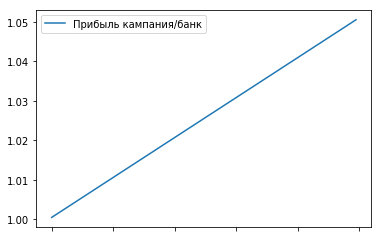

In [24]:
campain_effect_tmp.T[['Прибыль кампания/банк']].plot();

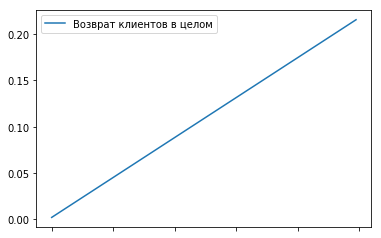

In [25]:
campain_effect_tmp.T[['Возврат клиентов в целом']].plot();

С ростом охвата кампанией уходящих клиентов линейно растет ее эффективность как в терминах дополнительной прибыли (до почти 5%), так и в терминах уменьшения скорости оттока (до более 20%).

__Рекомендуется:__ включать в кампанию 100% пользователей из списка, сформированного моделью.

In [26]:
model_params['fraction_of_clients'] = 1.

In [27]:
step = 'fraction_of_clients = 100%'
campain_params[step] = get_campain_params()
campain_effect[step] = get_campain_effect(campain_params[step])
campain_effect.T

,Прибыль кампания/банк,Затраты на кампанию,Возврат клиентов по кампании,Возврат клиентов в целом,Потери кампании
Начальные настройки,1.012627,0.008742,0.397049,0.053898,60.283688
fraction_of_clients = 100%,1.050505,0.034968,0.397077,0.215606,60.289407


In [28]:
campain_params.T

,clients_to_churn_for_campain,size_of_campaign,returned_clients,cost_of_campaign,profit_of_campaign,losses_of_campaign
Начальные настройки,64400,8742,3471,874200,861300,527000
fraction_of_clients = 100%,64400,34968,13885,3496800,3445700,2108200


Затраты на кампанию при этом возрастут, однако составят всего 3,5% от прибыли предыдущего месяца или в абсолютном значении 3,5 миллиона. А удержать удастся уже более 13 тысяч клиентов:

## Задание 3

_Попробуйте усложнить экономическую модель. Добавьте еще несколько параметров и поиграйте с ними (например, измените стоимость удержания и вероятность, с которой пользователь принимает предложение), проанализируйте как меняется оптимальный размер топа?_

__Стоимость удержания__

In [29]:
model_params_tmp = model_params.copy()
campain_params_tmp = pd.DataFrame(index = param_index)
campain_effect_tmp = pd.DataFrame(index = effect_index)
campain_params_res = pd.DataFrame(index = param_index)
campain_effect_res = pd.DataFrame(index = effect_index)
top_size = []
for i in range(10, model_params_tmp['income_from_client'] + 1):
    model_params_tmp['cost_of_withholding'] = i
    for j in range(1, 101):
        model_params_tmp['fraction_of_clients'] = j / 100.
        campain_params_tmp[j] = get_campain_params(model_params_tmp)
        campain_effect_tmp[j] = get_campain_effect(campain_params_tmp[j], model_params_tmp)
    size = campain_effect_tmp.T['Прибыль кампания/банк'].idxmax()
    top_size.append(size)
    model_params_tmp['fraction_of_clients'] = size / 100.
    step = str(i) + 'р. / ' + str(size) + '%'
    campain_params_res[step] = get_campain_params(model_params_tmp)
    campain_effect_res[step] = get_campain_effect(campain_params_res[step], model_params_tmp)

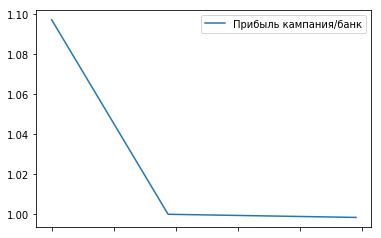

In [30]:
campain_effect_res.T[['Прибыль кампания/банк']].plot();

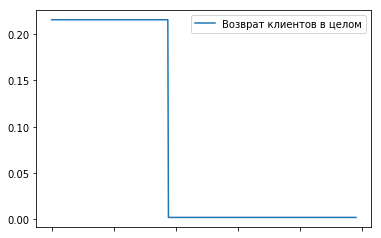

In [31]:
campain_effect_res.T[['Возврат клиентов в целом']].plot();

In [32]:
result = campain_effect_res.T
print(result[result['Прибыль кампания/банк'] >= 1]['Прибыль кампания/банк'].idxmin(), \
      result[result['Прибыль кампания/банк'] <= 1]['Прибыль кампания/банк'].idxmax())

197р. / 100% 198р. / 1%


In [33]:
campain_effect_res.loc[:, '197р. / 100%':'198р. / 1%']

,197р. / 100%,198р. / 1%
Прибыль кампания/банк,1.000201,0.999993
Затраты на кампанию,0.068887,0.000691
Возврат клиентов по кампании,0.397077,0.395415
Возврат клиентов в целом,0.215606,0.002143
Потери кампании,118.770133,118.856734


In [34]:
campain_params_res.loc[:, '197р. / 100%':'198р. / 1%']

,197р. / 100%,198р. / 1%
clients_to_churn_for_campain,64400,64400
size_of_campaign,34968,349
returned_clients,13885,138
cost_of_campaign,6888696,69102
profit_of_campaign,53804,-102
losses_of_campaign,4153154,41481


Прибыльность кампании с ростом расходов логично уменьшается, в какой-то момент переходя в убытки. 

Верхняя граница расходов на удержание одного клиента для сохранения доходности кампании составляет 197 р. при 100%-м охвате аудитории кампании. При этом ключевые показатели эффективности меняются не в лучшую сторону (прибыльность меньше, процент возврата такой же), а затраты на компанию многократно выше.

__Рекомендуется:__ снижать затраты на удержание клиента настолько, насколько это возможно без снижения доли принятия предложения. Поскольку к модели прогноза это не относится, пока оставлю величину расходов на удержание прежней (100 р.).

__Вероятность, с которой пользователь принимает предложение__

In [35]:
model_params_tmp = model_params.copy()
campain_params_tmp = pd.DataFrame(index = param_index)
campain_effect_tmp = pd.DataFrame(index = effect_index)
campain_params_res = pd.DataFrame(index = param_index)
campain_effect_res = pd.DataFrame(index = effect_index)
top_size = []
for i in range(1, 101):
    model_params_tmp['probability_of_accepting'] = i / 100.
    for j in range(1, 101):
        model_params_tmp['fraction_of_clients'] = j / 100.
        campain_params_tmp[j] = get_campain_params(model_params_tmp)
        campain_effect_tmp[j] = get_campain_effect(campain_params_tmp[j], model_params_tmp)
    size = campain_effect_tmp.T['Прибыль кампания/банк'].idxmax()
    top_size.append(size)
    model_params_tmp['fraction_of_clients'] = size / 100.
    step = str(i) + '% / ' + str(size) + '%'
    campain_params_res[step] = get_campain_params(model_params_tmp)
    campain_effect_res[step] = get_campain_effect(campain_params_res[step], model_params_tmp)

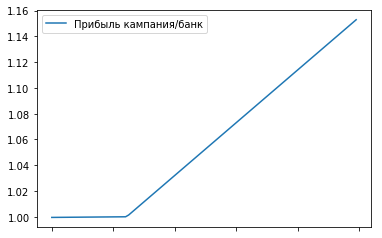

In [36]:
campain_effect_res.T[['Прибыль кампания/банк']].plot();

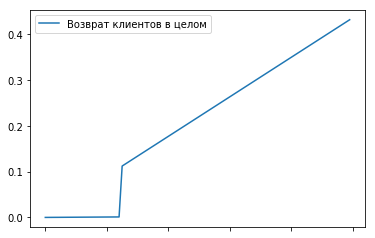

In [37]:
campain_effect_res.T[['Возврат клиентов в целом']].plot();

In [38]:
result = campain_effect_res.T
print(result[result['Прибыль кампания/банк'] <= 1]['Прибыль кампания/банк'].idxmax(), \
      result[result['Прибыль кампания/банк'] >= 1]['Прибыль кампания/банк'].idxmin())

25% / 1% 26% / 100%


In [39]:
campain_effect_res.loc[:, '25% / 1%':'26% / 100%']

,25% / 1%,26% / 100%
Прибыль кампания/банк,0.999991,1.001368
Затраты на кампанию,0.000349,0.034968
Возврат клиентов по кампании,0.197708,0.206474
Возврат клиентов в целом,0.001071,0.112112
Потери кампании,79.871060,79.349119


In [40]:
campain_params_res.loc[:, '25% / 1%':'26% / 100%']

,25% / 1%,26% / 100%
clients_to_churn_for_campain,64400,64400
size_of_campaign,349,34968
returned_clients,69,7220
cost_of_campaign,34900,3496800
profit_of_campaign,-400,113200
losses_of_campaign,27875,2774680


С ростом вероятности принятия клиентом предложения логично возрастает и прибыльность, и доля возврата. Но есть нижняя граница вероятности, меньше которой кампания будет убыточной - 26% при расходах на удержание в 100 р. При других расходах нижняя граница изменится (и наоборот), поэтому ее каждый раз нужно оценивать заново исходя из планируемых (и заранее оцененных) инструментов удержания.

__Стоимость удержания и вероятность принятия предложения__

In [41]:
model_params_tmp = model_params.copy()
campain_params_frac = pd.DataFrame(index = param_index)
campain_effect_frac = pd.DataFrame(index = effect_index)
campain_params_res = pd.DataFrame(index = param_index)
campain_effect_res = pd.DataFrame(index = effect_index)
profit = np.zeros((model_params_tmp['income_from_client'] - 9, 100))
top_size = []
for cost in range(10, model_params_tmp['income_from_client'] + 1):
    model_params_tmp['cost_of_withholding'] = cost
    for prob in range(1, 101):
        model_params_tmp['probability_of_accepting'] = prob / 100.
        for frac in range(1, 101):
            model_params_tmp['fraction_of_clients'] = frac / 100.
            campain_params_frac[j] = get_campain_params(model_params_tmp)
            campain_effect_frac[j] = get_campain_effect(campain_params_frac[j], model_params_tmp)
        size = campain_effect_frac.T['Прибыль кампания/банк'].idxmax()
        top_size.append(size)
        model_params_tmp['fraction_of_clients'] = size / 100.
        step = str(cost) + 'p : ' + str(prob) + '% : ' + str(size) + '%'
        campain_params_res[step] = get_campain_params(model_params_tmp)
        campain_effect_res[step] = get_campain_effect(campain_params_res[step], model_params_tmp)
        profit[cost - 10, prob - 1] = campain_effect_res[step].T['Прибыль кампания/банк']

In [42]:
threshold_from_probability = []
for i in range(100):
    res = profit[:, i]
    more = res[res >= 1]
    threshold_from_probability.append(np.where(res == more[-1])[0][0] if len(more) > 0 else -1)

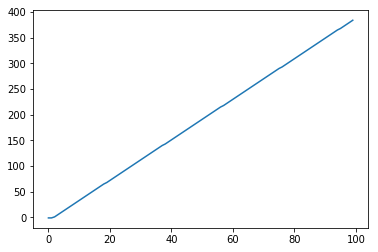

In [43]:
plt.plot(threshold_from_probability);

Зависимость ожидаемо линейная. Можно посмотреть на разные цифры:

In [44]:
prob = 5
print('При вероятности принятия предложения в {0}% максимально допустимые расходы на удержание 1 клиента составят {1} р.'\
                                                                      .format(prob, threshold_from_probability[prob]))

При вероятности принятия предложения в 5% максимально допустимые расходы на удержание 1 клиента составят 13 р.


In [45]:
prob = 25
print('При вероятности принятия предложения в {0}% максимально допустимые расходы на удержание 1 клиента составят {1} р.'\
                                                                      .format(prob, threshold_from_probability[prob]))

При вероятности принятия предложения в 25% максимально допустимые расходы на удержание 1 клиента составят 92 р.


In [46]:
prob = 50
print('При вероятности принятия предложения в {0}% максимально допустимые расходы на удержание 1 клиента составят {1} р.'\
                                                                      .format(prob, threshold_from_probability[prob]))

При вероятности принятия предложения в 50% максимально допустимые расходы на удержание 1 клиента составят 191 р.


In [47]:
prob = 75
print('При вероятности принятия предложения в {0}% максимально допустимые расходы на удержание 1 клиента составят {1} р.'\
                                                                      .format(prob, threshold_from_probability[prob]))

При вероятности принятия предложения в 75% максимально допустимые расходы на удержание 1 клиента составят 290 р.


## Задание 4

_Всегда ли применение модели экономически оправданно? Приведите пример набора значений параметров, при которых применение модели перестает быть оправданным._

Выше были приведены примеры, когда применение модели ведет к убыткам, например, расходы на удержание 1 клиента больше 13 р. при вероятности принятия предложения 5% и т.п.

## Задание 5

_Оцените изменение экономического эффекта от проведения кампании по удержанию при увеличении качества модели на 1%? На 3%? При ответе на вопрос укажите, по какой метрике вы оцениваете качество._

Предполагаю, что речь идет об увеличении оценки по метрике полноты по классу оттока:

In [50]:
model_params_tmp = model_params.copy()
campain_params_tmp = pd.DataFrame(index = param_index)
campain_effect_tmp = pd.DataFrame(index = effect_index)

step = 'recall = 48%'
model_params_tmp['recall_churn'] = model_params['recall_churn']
campain_params_tmp[step] = get_campain_params(model_params_tmp)
campain_effect_tmp[step] = get_campain_effect(campain_params_tmp[step], model_params_tmp)

step = 'recall = 49%'
model_params_tmp['recall_churn'] = model_params['recall_churn'] + .01
campain_params_tmp[step] = get_campain_params(model_params_tmp)
campain_effect_tmp[step] = get_campain_effect(campain_params_tmp[step], model_params_tmp)

step = 'recall = 51%'
model_params_tmp['recall_churn'] = model_params['recall_churn'] + .03
campain_params_tmp[step] = get_campain_params(model_params_tmp)
campain_effect_tmp[step] = get_campain_effect(campain_params_tmp[step], model_params_tmp)

step = 'recall = 100%'
model_params_tmp['recall_churn'] = model_params['recall_churn'] + .52
campain_params_tmp[step] = get_campain_params(model_params_tmp)
campain_effect_tmp[step] = get_campain_effect(campain_params_tmp[step], model_params_tmp)

In [51]:
campain_effect_tmp.T

,Прибыль кампания/банк,Затраты на кампанию,Возврат клиентов по кампании,Возврат клиентов в целом,Потери кампании
recall = 48%,1.050505,0.034968,0.397077,0.215606,60.289407
recall = 49%,1.052019,0.035712,0.398746,0.221118,60.122648
recall = 51%,1.055061,0.037200,0.401935,0.232174,59.802419
recall = 100%,1.132187,0.073656,0.444675,0.508587,55.531118


Увеличение прибыльности кампании составляет примерно 0.15% на каждый добавленный процент полноты. Скорость сокращения оттока на тот же процент полноты уменьшается на 0.5%.

Если удастся довести полноту до 100%, то прибыльность кампании возрастет до 13%, а скорость оттока упадет почти вдвое, что очень и очень много. Не забываем, что оставшаяся половина оттока - это потери по непринятию предложения (расчеты ведутся при вероятности 50%).

Посмотрим, как изменится картина, если удастся увеличить при этом и точность до 100%:

In [52]:
model_params_tmp = model_params.copy()
model_params_tmp['precision_churn'] = 1
campain_params_tmp = pd.DataFrame(index = param_index)
campain_effect_tmp = pd.DataFrame(index = effect_index)

step = 'recall = 48%'
model_params_tmp['recall_churn'] = model_params['recall_churn']
campain_params_tmp[step] = get_campain_params(model_params_tmp)
campain_effect_tmp[step] = get_campain_effect(campain_params_tmp[step], model_params_tmp)

step = 'recall = 49%'
model_params_tmp['recall_churn'] = model_params['recall_churn'] + .01
campain_params_tmp[step] = get_campain_params(model_params_tmp)
campain_effect_tmp[step] = get_campain_effect(campain_params_tmp[step], model_params_tmp)

step = 'recall = 51%'
model_params_tmp['recall_churn'] = model_params['recall_churn'] + .03
campain_params_tmp[step] = get_campain_params(model_params_tmp)
campain_effect_tmp[step] = get_campain_effect(campain_params_tmp[step], model_params_tmp)

step = 'recall = 100%'
model_params_tmp['recall_churn'] = model_params['recall_churn'] + .52
campain_params_tmp[step] = get_campain_params(model_params_tmp)
campain_effect_tmp[step] = get_campain_effect(campain_params_tmp[step], model_params_tmp)

In [53]:
campain_effect_tmp.T

,Прибыль кампания/банк,Затраты на кампанию,Возврат клиентов по кампании,Возврат клиентов в целом,Потери кампании
recall = 48%,1.056651,0.025712,0.5,0.199627,50.0
recall = 49%,1.058290,0.026456,0.5,0.205404,50.0
recall = 51%,1.061568,0.027944,0.5,0.216957,50.0
recall = 100%,1.141845,0.064400,0.5,0.500000,50.0


Дополнительный процент точности даже при той же полноте увеличит прибыльность на 0.9%, что в 6 раз больше, чем "цена" процента полноты:

Максимальная (дополнительная!) прибыльность, которую можно достичь моделью при идеальных точности и полноте и остальных базовых параметрах составляет 14%. При других параметрах (расходах на удержание, вероятности принятия предложения и т.п.) эта цифра будет другой.

## Задание 6

_Как вы думаете, является ли экономически оправданным вложение средств в улучшение качества модели? На сколько нужно улучшить модель, чтобы это качественно сказалось на экономическом эффекте от удержания?_

По сути, на этот вопрос я уже ответила в предыдущем задании. Формулировка "качественно сказалось на экономическом эффекте от удержания" слишком тесто связана с реальным бизнесом, чтобы ее оценить сейчас. Для одной организации значимым будет эффект в 1%, а для другой и 10% покажется мало.

На самом деле, для проведения адекватного анализа нужны не только реальные бизнес-показатели, которые я в самом начале взяла с потолка, но и (повторюсь) горизонт анализа минимум в квартал, а лучше в 6 месяцев. 

Для диплома вполне достаточно показать подход к проведению анализа и общую оценку модели - она слабая, но все же не бесполезная. Улучшать ее смысл есть и есть куда. Если будет поставлена такая задача, то алгоритм действий:

- улучшить точность до 100%,

- с сохранением такой точности максимально увеличивать полноту.